In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.models import Model, load_model
import cv2

import matplotlib as mpl
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
import glob
import re
from time import gmtime, strftime, sleep
mpl.rcParams['figure.figsize'] = (8.0, 4.0) 

from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU,Softmax

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu

from quad_solver import solver

In [8]:
def initialFocus(sid=2):
    #10.42.0.90: local 10.236.176.152: ip
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=2, pos=512):
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=2, pos=512):
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grabImage(sid=2, imres=8):
# I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images

    subprocess.run('rsh nvidia@10.236.176.152 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)

    # ok, now let's grab an image on the tegra
    subprocess.run('rsh nvidia@10.236.176.152 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('rcp nvidia@10.236.176.152:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    #pop=skimage.transform.rotate(pop,180)
    subprocess.run('mv dbGrab* photo_arch/', \
                   stdout=subprocess.PIPE, shell=True)
    return pop

In [9]:
def patchExtraction(sid = 2):
    I = grabImage()

    I = skimage.color.rgb2gray(I)

    m, n= I.shape

    patch = I[m//2-256:m//2+256, n//2-256:n//2+256]
    patch = (patch - patch.min()) / (patch.max() - patch.min())
    return patch


In [10]:
initialFocus(sid=2)

b'sensor-id:2\nDemo Initialize\nDemo Start\nOIS Initilize\nEEPROM Read:\n  00 33 00 35 01 F5 02 01 FE 32 FE 86 00 1A 00 1B \n  08 1E 08 09 00 74 19 00 16 4E 29 24 D6 DC 20 00 \n  20 00 00 00 00 00 00 00 01 D8 10 00 00 01 00 01 \n  Gyro gain:6400(x1.00), 5710(x1.00)\nset: [Init:OIS] slave=1a, address=30ac, RegData = 01\n[Init:i2cdat_gyro]\nset: [Init:Start download] slave=3e, address=f010, RegData = 00\n[Init:DownloadProgram1]................................\n[Init:DownloadProgram2]....\n[Init:Calibration]\nset: [Init:Set OIS complete DL] slave=3e, address=f006, RegData = 00\nset: [Init:Servo on] slave=3e, address=6020, RegData = 01\nset: [Init:Gyro on] slave=3e, address=6023, RegData = 02\nset: [Init:Gyro on] slave=3e, address=602c, RegData = 1b\nset: [Init:Gyro on] slave=3e, address=602d, RegData = 10\nset: [Init:Gyro on] slave=3e, address=6023, RegData = 00\n[Init:GPO]\n[Init:PWM frequency]\nset: [OIS Hall current X] slave=3e, address=60a2, RegData = 37\nset: [OIS Hall current Y] sla

In [11]:
input_image1 = Input(shape=(512,512,1), name = "input")
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
layer1_1 = Conv2D(1, (8, 8), 8,padding='same',activation=relu, name="Conv1_1")(input_image1)

layer2_1 = Conv2D(1, (8, 8), 8,padding='same',activation=relu, name="Conv2_1")(layer1_1)

#layer3_1 = Conv2D(32, (3, 3), 2,padding='same',activation=relu, name="Conv3_1")(layer2_1)

#layer4_1 = Conv2D(32, (3, 3), 2,padding='same',activation=relu, name="Conv4_1")(layer3_1)

flattened = Flatten(name="flat")(layer2_1)

dense1 = Dense(10, name="d1")(flattened)
Dp1 = Dropout(0.5)(dense1)
# ReLU1 = ReLU(name="lr1")(dense1)

output_position = Dense(2, activation='softmax', name="out")(Dp1)

print(output_position)

discriminator = Model(inputs=input_image1, outputs=output_position)
discriminator.load_weights('best_dis_weights.h5')
#discriminator = load_model('net_para/my_model_dis_512.h5')
model = load_model('050-0.65.hdf5')

Tensor("out_2/Softmax:0", shape=(?, 2), dtype=float32)


1.0


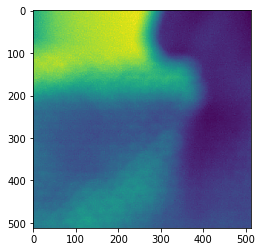

In [14]:
curr = 1000
setFocus(sid=2, pos=curr)
patch = patchExtraction(sid =2)
print(patch.max())
plt.imshow(patch)

In [15]:
pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
print(pred)

[0.62322205 0.37677795]


In [88]:
# # # from tensorflow.python.keras import backend as K

# # # inp = model.input                                           # input placeholder
# # # outputs = [layer.output for layer in model.layers]          # all layer outputs
# # # functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# # # # Testing
# # # layer_outs = [func([patch[np.newaxis,:,:, np.newaxis], 1.]) for func in functors]
# # # print(layer_outs)
# # get_all_layer_outputs = Kpatch = patchExtraction(sid = 1)
# print(patch.max())
# plt.imshow(patch).function([discriminator.layers[0].input],
# #                                   [l.output for l in discriminator.layers[1:]])

# # layer_output = get_all_layer_outputs([patch[np.newaxis,:,:, np.newaxis]])
# # print(layer_output[4])

New Round -----------Current pos:  1000
6.4548936
curr0:  nan curr1:  577.4757578076274
branch3
curr:  577.4757578076274


/home/qian/Documents/autofocus/quad_solver.py:9: RuntimeWarning: invalid value encountered in sqrt
  sol1 = (-b + np.sqrt(d1))/(2*a2)
/home/qian/Documents/autofocus/quad_solver.py:11: RuntimeWarning: invalid value encountered in sqrt
  sol3 = (-b - np.sqrt(d1))/(2*a2)


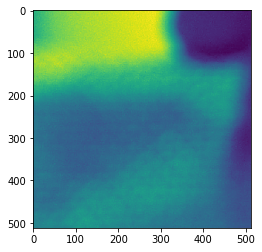

[0.62322205 0.37677795]
New Round -----------Current pos:  577.4757578076274
5.970863
curr0:  942.7218418606049 curr1:  358.4956758681467
branch2
curr:  942.7218418606049


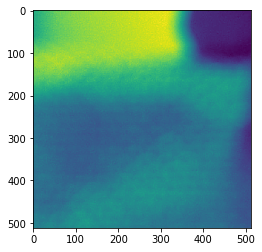

[0.6217107  0.37828928]
New Round -----------Current pos:  942.7218418606049
7.6803784
curr0:  nan curr1:  507.64027021015863
branch3
curr:  507.64027021015863


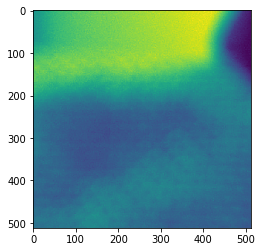

[0.62322205 0.37677795]
New Round -----------Current pos:  507.64027021015863
5.575772
curr0:  776.1442556740213 curr1:  317.57868085758275
branch2
curr:  776.1442556740213


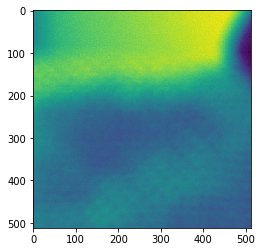

[0.62322205 0.37677795]
New Round -----------Current pos:  776.1442556740213
6.6109877
curr0:  nan curr1:  468.59635062443454
branch3
curr:  468.59635062443454


KeyboardInterrupt: 

In [16]:
while (pred[0] > pred[1]):  
    print("New Round -----------Current pos: ", curr)

    step = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
    print(step)
    if step < 0.5:
        break
    
    curr0 = curr + solver(curr, step)[0]
    curr1 = curr + solver(curr, step)[1]
    print("curr0: ", curr0, "curr1: ", curr1)
    if curr0 > 1023 and curr1 < 425:
        print("branch1")
        break
    elif curr0  < 1023 and curr1 < 425:
        print("branch2")
        curr = curr0
        print("curr: ", curr)
        setFocus(sid=1, pos=curr)

        patch = patchExtraction(sid = 1)
        plt.imshow(patch)
        plt.show()

        pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
        print(pred)
    elif (curr0  > 1023 and curr1 > 425) or (np.isnan(curr0)):
        print("branch3")
        curr = curr1
        print("curr: ", curr)
        setFocus(sid=1, pos=curr)

        patch = patchExtraction(sid = 1)
        plt.imshow(patch)
        plt.show()

        pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
        print(pred)
    else:
        print("branch4")
        setFocus(sid=1, pos=curr0)
        patch0 = patchExtraction(sid = 1)
        step0 = model.predict(patch0[np.newaxis,:,:, np.newaxis])[0][0]
        print("step0: ", step0)
        setFocus(sid=1, pos=curr1)
        patch1 = patchExtraction(sid = 1)
        step1 = model.predict(patch1[np.newaxis,:,:, np.newaxis])[0][0]
        print("step1: ", step1)
        if step0 < step1:
            curr = curr0
            patch = patch0
        else:
            curr = curr1
            patch = patch1
        print("curr: ", curr)
            
        pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
        print(pred)
            

# setFocus(1, curr + 100*step)
# patch2 = patchExtraction(sid = 1)
# plt.imshow(patch)
# plt.show()
# temp2 = model.predict(patch2[np.newaxis,:,:, np.newaxis])[0][0]
# print(temp2)


# if temp <= temp2:
#     setFocus(sid=1, pos=curr-step*100)
#     curr = max(curr-step*100, 0)
#     pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
#     print(pred)
# else:
#     curr = min(curr+step*100, 1023)
#     pred = discriminator.predict(patch2[np.newaxis,:,:, np.newaxis])[0]
#     print(pred)

print("Current pos: ", curr)

In [84]:
# print("Current pos: ", curr)
# while (pred[0] > pred[1]):    
#     step = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
#     print(step)

#     setFocus(sid=1, pos=curr-step*100)

#     patch = patchExtraction(sid = 1)
#     plt.imshow(patch)
#     plt.show()

#     temp = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
#     print(temp)


#     setFocus(1, curr + 100*step)
#     patch2 = patchExtraction(sid = 1)
#     plt.imshow(patch)
#     plt.show()
#     temp2 = model.predict(patch2[np.newaxis,:,:, np.newaxis])[0][0]
#     print(temp2)
    
    
#     if temp <= temp2:
#         setFocus(sid=1, pos=curr-step*100)
#         curr = max(curr-step*100, 0)
#         pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
#         print(pred)
#     else:
#         curr = min(curr+step*100, 1023)
#         pred = discriminator.predict(patch2[np.newaxis,:,:, np.newaxis])[0]
#         print(pred)
        
#     print("Current pos: ", curr)